In [1]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from scipy import stats
from scipy import optimize
import joblib
import matplotlib.pyplot as plt

#working directory (needed for saving models)
filepath_wd = ".../Resultate_final/working_directory/"
#directory for results
filepath = ".../Resultate_final/VarAnn/saved_single_run/"

In [2]:
#parameters as in section 4.3 of 'Assessing Asset-Liability risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
#and section 5.1 of 'A Least-Squares Monte Carlo Approach to the Estimation of Enterprise Risk' (Ha, Bauer 2019)
#parameters for q
q_0 = 4.605
m = 0.05
sigma_S = 0.18
#parameters for r
r_0 = 0.025
zeta = 0.25
gamma = 0.02
sigma_r = 0.01
lambd = 0.02
gamma_bar = gamma - (lambd*sigma_r)/zeta
#parameters for mu_(55+t)
mu_55 = 0.01
kappa = 0.07
sigma_mu = 0.0012
#parameters for brownian motion
rho_12 = -0.3
rho_13 = 0.06
rho_23 = -0.04
cov_mat = np.array([[1,rho_12,rho_13],[rho_12,1,rho_23],[rho_13,rho_23,1]])
#horizon parameters
tau = 1
T = 15
b = 10.792
#GlueVaR parameters
alpha_Glue = 0.95
beta_Glue = 0.995
omega_Glue = np.array([1/3,1/3])

In [3]:
#Sizes for training, validation, test, and set size for Monte Carlo estimation of the risk measures
M_1 = 1500000
M_2 = 500000
M_3 = 500000
#ignore N or N_2 in the following. Was kept just in case, but not used.
N_2 = 1
M_MC = 500000
#size of the set of data points used to calculate an IS density
M_IS = 750000
#quantile for which the IS density will be computed
alpha_IS = 0.975

In [4]:
#Definition of these functions analogously to the appendix of 'A Least-Squares Monte Carlo Approach to the Estimation of Enterprise Risk' (Ha, Bauer 2019)
def B_r(t,T):
    return ((1-np.exp(-zeta*(T-t)))/zeta)
def B_mu(t,T):
    return ((np.exp(kappa*(T-t))-1)/kappa)
def A(t,T):
    tmp1 = gamma_bar*(B_r(t,T)-(T-t))
    tmp2 = (sigma_r/zeta)**2 * ((T-t) - 2*B_r(t,T) + (1-np.exp(-2*zeta*(T-t)))/(2*zeta))
    tmp3 = (sigma_mu/kappa)**2 * ((T-t) - 2*B_mu(t,T) + (np.exp(2*kappa*(T-t))-1)/(2*kappa))
    tmp4 =  2*rho_23*sigma_r*sigma_mu/(zeta*kappa) * (B_mu(t,T) - (T-t) + B_r(t,T) - (1-np.exp(-(zeta-kappa)*(T-t)))/(zeta-kappa))
    return np.exp(tmp1+0.5*(tmp2+tmp3+tmp4))
#Definition of this function analogously to section 4.3 of 'Assessing Asset-Liability risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
def F(t,k,r_t,mu_xt):
    return (A(t,t+k)*np.exp(-B_r(t,t+k)*r_t - B_mu(t,t+k)*mu_xt))

#parameters of the normal distribution of X_tau according to the appendix of 'A Least-Squares Monte Carlo Approach to the Estimation of Enterprise Risk' (Ha, Bauer 2019)
mu_q_tau = q_0 + (m-0.5*(sigma_S**2))*tau
mu_r_tau = r_0*np.exp(-zeta*tau) + gamma*(1-np.exp(-zeta*tau))
mu_mu_55_tau = mu_55*np.exp(kappa*tau)
mean_tau = np.array([mu_q_tau, mu_r_tau, mu_mu_55_tau])

cov_q_r_tau = rho_12*sigma_S*sigma_r*B_r(0,tau)
cov_q_mu_tau = rho_13*sigma_S*sigma_mu*B_mu(0,tau)
cov_r_mu_tau = rho_23*sigma_r*sigma_mu* ((1-np.exp(-(zeta-kappa)*tau))/(zeta-kappa))
var_q_tau = (sigma_S**2) * tau
var_r_tau = (sigma_r**2) * ((1-np.exp(-2*zeta*tau))/(2*zeta))
var_mu_tau = (sigma_mu**2) * ((np.exp(2*kappa*tau)-1)/(2*kappa))
cov_mat_tau = np.array([[var_q_tau, cov_q_r_tau, cov_q_mu_tau], [cov_q_r_tau, var_r_tau, cov_r_mu_tau], [cov_q_mu_tau, cov_r_mu_tau, var_mu_tau]])
C_tau = np.linalg.cholesky(cov_mat_tau)

#variance/covariance parameters of the conditional normal distribution of X_T according to the appendix of 'A Least-Squares Monte Carlo Approach to the Estimation of Enterprise Risk' (Ha, Bauer 2019)
var_q_T_cond = (sigma_S**2) *(T-tau) + ((sigma_r/zeta)**2) * (T-tau - 2*(1-np.exp(-zeta*(T-tau)))/zeta + (1-np.exp(-2*zeta*(T-tau)))/(2*zeta)) + (2*rho_12*sigma_S*sigma_r/zeta) * (T-tau- (1-np.exp(-zeta*(T-tau)))/zeta)
cov_q_r_T_cond = rho_12*sigma_S*sigma_r*((1-np.exp(-zeta*(T-tau)))/zeta) + ((sigma_r**2)/zeta) * ((1-2*np.exp(-zeta*(T-tau))+np.exp(-2*zeta*(T-tau)))/(2*zeta))
cov_q_mu_T_cond = rho_13*sigma_S*sigma_mu *((np.exp(kappa*(T-tau))-1)/kappa) + (rho_23*sigma_r*sigma_mu/zeta) * ((np.exp(kappa*(T-tau))-1)/kappa - (1-np.exp(-(zeta-kappa)*(T-tau)))/(zeta-kappa))
var_r_T_cond = (sigma_r**2) * ((1-np.exp(-2*zeta*(T-tau)))/(2*zeta))
cov_r_mu_T_cond = rho_23*sigma_r*sigma_mu*((1-np.exp(-(zeta-kappa)*(T-tau)))/(zeta-kappa))
var_mu_T_cond = (sigma_mu**2) * ((np.exp(2*kappa*(T-tau))-1)/(2*kappa))
cov_mat_T_cond = np.array([[var_q_T_cond, cov_q_r_T_cond, cov_q_mu_T_cond], [cov_q_r_T_cond, var_r_T_cond, cov_r_mu_T_cond], [cov_q_mu_T_cond, cov_r_mu_T_cond, var_mu_T_cond]])

#function for generating simulated risk factors X_tau and corresponding payments Y from multivariate standard normal random variables
def data_gen(Z,V):
    #simulation of X_tau
    X_tau = np.transpose(np.matmul(C_tau,np.transpose(Z))) + np.tile(mean_tau, (len(Z),1))

    #simulation of X_T given X_tau
    mu_q_T_cond = X_tau[:,0] + B_r(tau,T)*X_tau[:,1] + (gamma_bar - (sigma_r/zeta)**2)*(T-tau - (1-np.exp(-zeta*(T-tau)))/zeta) + 0.5*((sigma_r/zeta)**2) * ((1-np.exp(-zeta*(T-tau)))/zeta - (np.exp(-zeta*(T-tau))-np.exp(-2*zeta*(T-tau)))/zeta) - ((rho_23*sigma_r*sigma_mu)/kappa) * ( (np.exp(kappa*(T-tau))-1)/(kappa*(zeta-kappa)) - (np.exp(kappa*(T-tau))-np.exp(-(zeta-kappa)*(T-tau)))/(zeta*(zeta-kappa)) - (1/zeta) * (T-tau - (1-np.exp(-zeta*(T-tau)))/zeta)) -0.5*(sigma_S**2) * (T-tau) - (rho_12*sigma_S*sigma_r/zeta) * (T-tau - (1-np.exp(-zeta*(T-tau)))/zeta) - (rho_13*sigma_S*sigma_mu/kappa) * ((np.exp(kappa*(T-tau))-1)/kappa -T+tau)
    mu_r_T_cond = np.exp(-zeta*(T-tau))*X_tau[:,1] + (gamma_bar-(sigma_r/zeta)**2)*(1-np.exp(-zeta*(T-tau))) + 0.5*((sigma_r/zeta)**2) *(1-np.exp(-2*zeta*(T-tau))) - (rho_23*sigma_r*sigma_mu/kappa) * ((1-np.exp(-(zeta-kappa)*(T-tau)))/(zeta-kappa) - (1-np.exp(-zeta*(T-tau)))/zeta)
    mu_mu_T_cond = np.exp(kappa*(T-tau))*X_tau[:,2] - (rho_23*sigma_r*sigma_mu/zeta) * ((np.exp(kappa*(T-tau))-1)/kappa - (1-np.exp(-(zeta-kappa)*(T-tau)))/(zeta-kappa)) - ((sigma_mu**2)/kappa) * ((np.exp(2*kappa*(T-tau))-1)/(2*kappa) - (np.exp(kappa*(T-tau))-1)/kappa)
    mean_T_cond = np.array([mu_q_T_cond, mu_r_T_cond, mu_mu_T_cond])

    X_T = V + np.transpose(mean_T_cond)
    
    #calculation of Y from X_T and X_tau
    Y = F(t=tau, k=T-tau, r_t=X_tau[:,1], mu_xt=X_tau[:,2]) * np.maximum(np.exp(X_T[:,0]), b*np.sum([F(t=T, k=i, r_t=X_T[:,1], mu_xt=X_T[:,2]) for i in range(1,51)], axis=0))
    return X_tau, Y

#the function DT(Z,\theta)
def data_trans_IS(Z,IS):
    res = np.empty((len(Z),3))
    for j in range(3):
        res[:,j] = Z[:,j]*np.sqrt(IS[3+j]) + IS[j]
    return res

#The density function of Z
def f(y):
    return stats.multivariate_normal.pdf(y, mean=np.full(3,0), cov=np.identity(3))

#The density function of Z_\theta (note that x is interpreted as theta, needed for the least-squares solver to work properly)
def f_theta(y, x):
    return stats.multivariate_normal.pdf(y, mean=x[0:3], cov=np.diag(x[3:6]))

#This function describes the approximation of the expression inside the sum of m_2(theta)
def g_VaR_hat_reweighted(x,L,q_alpha_hat):
    return [(np.sqrt(f(y=L[i,0:3])/f_theta(x=x, y=L[i,0:3])) if L[i,-1]>q_alpha_hat else 0) for i in range(len(L))]

#bounds for the IS density parameters (for the parameters corresponding to the mean no bounds are necessary, the standard deviation parameters however needs to be non-negative)
bnds_lower = np.array([-np.inf, -np.inf, -np.inf, 0,0,0])
bnds_upper = np.full(6,np.inf)
bnds = (bnds_lower, bnds_upper)

#function for calculating GlueVaR in an IS setting
def GlueVaR_IS(omega, L, alpha, beta, w):
    j_beta = 0
    w_sum_tmp = 0
    while(w_sum_tmp <= (1-beta)):
        w_sum_tmp += w[j_beta]
        j_beta += 1
        
    j_alpha = j_beta
    while(w_sum_tmp <= (1-alpha)):
        w_sum_tmp += w[j_alpha]
        j_alpha += 1
        
    ES_beta = 1/(1-beta) * np.sum(w[0:j_beta-1]*L[0:j_beta-1]) + ( 1 - (1 / (1-beta)) * np.sum(w[0:j_beta-1]) )*L[j_beta]
    ES_alpha = 1/(1-alpha) * np.sum(w[0:j_alpha-1]*L[0:j_alpha-1]) + ( 1 - (1 / (1-alpha)) * np.sum(w[0:j_alpha-1]) )*L[j_alpha]
    VaR_alpha = L[j_alpha]

    return omega[0]*ES_beta + omega[1]*ES_alpha + (1-omega[0]-omega[1])*VaR_alpha

In [5]:
#Generating realisations of multivariate standard normal random variables
Z_IS = np.random.multivariate_normal(mean=np.full(3,0), cov=np.identity(3), size=M_IS)
V_IS = np.random.multivariate_normal(mean=np.full(3,0), cov=cov_mat_T_cond, size=M_IS)

#Calculate the risk factor X_tau and the corresponding simulated payoffs Y
X_tau_IS, Y_IS = data_gen(Z=Z_IS, V=V_IS)

#define and compile neural network model, setup as in section 4.3 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
bi_IS = np.log( np.sum(Y_IS)/len(Y_IS))
model_IS = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),
    tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(1, activation='exponential', bias_initializer=tf.keras.initializers.Constant(value=bi_IS))])
model_IS.compile(loss='mse', optimizer='adam', metrics=['mse'])
model_IS.fit(x=X_tau_IS, y=Y_IS, epochs=40, batch_size=10000, verbose=0)

#Calculate realisations of L_hat from the training data set using the trained neural network
L_hat_IS = np.column_stack((Z_IS, model_IS.predict(X_tau_IS)[:,0]))
L_hat_IS_sort = L_hat_IS[L_hat_IS[:,-1].argsort()[::-1]]

#Calculating the corresponding estimator for Value-at-Risk in order to approximate g
q_alpha_IS_hat = L_hat_IS_sort[int(M_IS*(1-alpha_IS)-1), -1]
print('q_alpha_IS_hat:',q_alpha_IS_hat)

#Calculating the (hopefully) approximately optimal \theta^*_{NN} by minimising m_2 using the approximated g
IS_NN = optimize.least_squares(g_VaR_hat_reweighted, x0=np.concatenate((np.full(3,0),np.full(3,1))), args=(L_hat_IS, q_alpha_IS_hat), bounds=bnds).x

#define and train a random forest according to the optimal parameters from tuning
rfr_IS = RandomForestRegressor(n_estimators=160, criterion='squared_error', max_features=2, min_samples_leaf=1300, bootstrap=True, verbose=0, n_jobs=-1)
rfr_IS.fit(X=X_tau_IS, y=Y_IS)

#Calculate realisations of L_hat from the training data set using the trained random forest
L_hat_IS = np.column_stack((Z_IS, rfr_IS.predict(X_tau_IS)))
L_hat_IS_sort = L_hat_IS[L_hat_IS[:,-1].argsort()[::-1]]

#Calculating the corresponding estimator for Value-at-Risk in order to approximate g
q_alpha_IS_hat = L_hat_IS_sort[int(M_IS*(1-alpha_IS)-1), -1]
print('q_alpha_IS_hat:',q_alpha_IS_hat)

#Calculating the (hopefully) approximately optimal \theta^*_{RF} by minimising m_2 using the approximated g
IS_RF = optimize.least_squares(g_VaR_hat_reweighted, x0=np.concatenate((np.full(3,0),np.full(3,1))), args=(L_hat_IS, q_alpha_IS_hat), bounds=bnds).x

#print IS density parameters for checking
print(IS_NN)
print(IS_RF)

2021-11-03 11:16:28.243531: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-03 11:16:30.341349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 206 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0
2021-11-03 11:16:30.343114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30529 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0
2021-11-03 11:16:30.344628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/

q_alpha_IS_hat: 129.5207977294922
q_alpha_IS_hat: 128.37939567910814
[ 1.80505702 -0.35828595 -1.19142987  0.48502229  0.88808866  0.93803208]
[ 1.99976265 -0.05792305 -0.82085621  0.34539151  0.98741398  1.29630836]


In [6]:
#Generating simulations of multivariate standard normal random variables for training set, validation set, test set, set for Monte Carlo estimation of risk measures
Z_train = np.random.multivariate_normal(mean=np.full(3,0), cov=np.identity(3), size=M_1)
V_train = np.random.multivariate_normal(mean=np.full(3,0), cov=cov_mat_T_cond, size=M_1)
Z_val = np.random.multivariate_normal(mean=np.full(3,0), cov=np.identity(3), size=M_2)
V_val = np.random.multivariate_normal(mean=np.full(3,0), cov=cov_mat_T_cond, size=M_2)
Z_test = np.random.multivariate_normal(mean=np.full(3,0), cov=np.identity(3), size=M_3)
V_test = np.random.multivariate_normal(mean=np.full(3,0), cov=cov_mat_T_cond, size=M_3)
Z_MC = np.random.multivariate_normal(mean=np.full(3,0), cov=np.identity(3), size=M_MC)
V_MC = np.random.multivariate_normal(mean=np.full(3,0), cov=cov_mat_T_cond, size=M_MC)

#calculate DT(Z,\theta^*_{NN})
Z_train_NN = data_trans_IS(Z_train,IS_NN)
Z_val_NN = data_trans_IS(Z_val,IS_NN)
Z_test_NN = data_trans_IS(Z_test,IS_NN)
Z_MC_NN = data_trans_IS(Z_MC,IS_NN)
#calculating the risk factors under the IS distribution and corresponding payoffs
X_tau_train_NN, Y_train_NN = data_gen(Z=Z_train_NN, V=V_train)
X_tau_val_NN, Y_val_NN = data_gen(Z=Z_val_NN, V=V_val)
X_tau_test_NN, Y_test_NN = data_gen(Z=Z_test_NN, V=V_test)
X_tau_MC_NN, Y_MC_NN = data_gen(Z=Z_MC_NN, V=V_MC)

#calculate DT(Z,\theta^*_{RF})
Z_train_RF = data_trans_IS(Z_train,IS_RF)
Z_val_RF = data_trans_IS(Z_val,IS_RF)
Z_test_RF = data_trans_IS(Z_test,IS_RF)
Z_MC_RF = data_trans_IS(Z_MC,IS_RF)
#calculating the risk factors under the IS distribution and corresponding payoffs
X_tau_train_RF, Y_train_RF = data_gen(Z=Z_train_RF, V=V_train)
X_tau_val_RF, Y_val_RF = data_gen(Z=Z_val_RF, V=V_val)
X_tau_test_RF, Y_test_RF = data_gen(Z=Z_test_RF, V=V_test)
X_tau_MC_RF, Y_MC_RF = data_gen(Z=Z_MC_RF, V=V_MC)

In [7]:
#calculating parameters for the sets B_1 and B_2
q_70 = stats.norm.ppf(0.7, loc=mu_q_tau, scale=var_q_tau)
q_30 = stats.norm.ppf(0.3, loc=mu_q_tau, scale=var_q_tau)
r_70 = stats.norm.ppf(0.7, loc=mu_r_tau, scale=var_r_tau)
r_30 = stats.norm.ppf(0.3, loc=mu_r_tau, scale=var_r_tau)

#calculate the indices of the set B_1 and B_2 for the test set created with the IS density calculated by the neural network
B_1_NN = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (X_tau_test_NN[:,0] > q_70, X_tau_test_NN[:,1] < r_30)) )
B_2_NN = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (X_tau_test_NN[:,0] < q_30, X_tau_test_NN[:,1] > r_70)) )

#calculate the indices of the set B_1 and B_2 for the test set created with the IS density calculated by the random forest
B_1_RF = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (X_tau_test_RF[:,0] > q_70, X_tau_test_RF[:,1] < r_30)) )
B_2_RF = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (X_tau_test_RF[:,0] < q_30, X_tau_test_RF[:,1] > r_70)) )

In [8]:
#define and compile neural network model, setup as in section 4.3 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
bi = np.log( np.sum(Y_train_NN)/len(Y_train_NN))
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),
    tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(4, activation='tanh'),
    tf.keras.layers.Dense(1, activation='exponential', bias_initializer=tf.keras.initializers.Constant(value=bi))])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#function for saving models after each epoch for later evaluation
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath_wd + "PTF_IS_1_saved_epoch_{epoch:01d}.hdf5", monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
#training the neural network
hist = model.fit(x=X_tau_train_NN, y=Y_train_NN, epochs=40, batch_size=10000, validation_data=(X_tau_val_NN,Y_val_NN), callbacks=[checkpoints])

#loading the saved models after every epoch
models_eval = []
for i in range(1,41):
    models_eval.append(tf.keras.models.load_model(filepath_wd + "PTF_IS_1_saved_epoch_" + str(i) + ".hdf5"))
    
#computation of the metrics (a), (b), (c) with B_1 and (c) with B_2
metric_a_NN = []
metric_b_NN = []
metric_c_B_1_NN = []
metric_c_B_2_NN = []
metric_c_B_1_NN = []
metric_c_B_2_NN = []
mse_train_NN = hist.history['mse'][-1]
mse_val_NN = hist.history['val_mse'][-1]

for j in range(40):
    Y_pred_tmp = models_eval[j].predict(X_tau_test_NN)[:,0]
    mc_tmp = Y_pred_tmp - Y_test_NN
    metric_a_NN.append(np.sum(mc_tmp)/len(Y_test_NN))
    metric_b_NN.append(np.sum((mc_tmp)*Y_pred_tmp)/len(Y_test_NN))
    metric_c_B_1_NN.append(np.sum(mc_tmp[B_1_NN])/len(Y_test_NN))
    metric_c_B_2_NN.append(np.sum(mc_tmp[B_2_NN])/len(Y_test_NN))

GlueVaR_hat_NN = []

#computation of expected payoffs depending on the risk factor X_tau according to the models, i.e. computation of L_hat_i's
L_hat_NN = model.predict(X_tau_MC_NN)[:,0]
L_hat_c_NN = np.column_stack((Z_MC_NN, L_hat_NN))

#calculation of risk measures in a stepwise procedure
#number of steps
step_number = 200
#step size
i = 500000/step_number

for n in range(1, step_number+1):
    #use first k simulations of L_hat
    k = int(n*i)
    L_hat_c_step_NN = L_hat_c_NN[0:k,:]
    
    #calculation of the IS estimator for GlueVaR
    L_hat_c_step_sort_NN = L_hat_c_step_NN[L_hat_c_step_NN[:,-1].argsort()[::-1]]
    w = f(L_hat_c_step_sort_NN[:,0:3])/(k*f_theta(x=IS_NN, y=L_hat_c_step_sort_NN[:,0:3]))

    GlueVaR_hat_NN.append(GlueVaR_IS(omega=omega_Glue, L=L_hat_c_step_sort_NN[:,-1], alpha=alpha_Glue, beta=beta_Glue, w=w))

Epoch 1/40
150/150 [==============================] - 1s 2ms/step - loss: 11707.6855 - mse: 11707.6855 - val_loss: 15136.9980 - val_mse: 15136.9980
Epoch 2/40
150/150 [==============================] - 0s 2ms/step - loss: 7773.0449 - mse: 7773.0449 - val_loss: 6448.9072 - val_mse: 6448.9072
Epoch 3/40
150/150 [==============================] - 0s 2ms/step - loss: 7124.7212 - mse: 7124.7212 - val_loss: 6220.9980 - val_mse: 6220.9980
Epoch 4/40
150/150 [==============================] - 0s 2ms/step - loss: 7092.1919 - mse: 7092.1924 - val_loss: 6187.1924 - val_mse: 6187.1924
Epoch 5/40
150/150 [==============================] - 0s 1ms/step - loss: 7090.5459 - mse: 7090.5459 - val_loss: 6172.7285 - val_mse: 6172.7285
Epoch 6/40
150/150 [==============================] - 0s 1ms/step - loss: 7090.2783 - mse: 7090.2783 - val_loss: 6169.8057 - val_mse: 6169.8057
Epoch 7/40
150/150 [==============================] - 0s 2ms/step - loss: 7090.1582 - mse: 7090.1582 - val_loss: 6169.5308 - val_mse

In [26]:
#perform a grid search in order to find the (approximately) best hyperparameter min_samples_leaf and max_features
#values that will be checked
max_features_list = [1,2]
min_samples_leaf_list = [1500,1750,2000,2250,2500,2750,3000,3250,3500]
opt_param = np.full(2,0)
opt_score = np.inf

for max_features in max_features_list:
    for min_samples_leaf in min_samples_leaf_list:
        rfr_tuning = RandomForestRegressor(n_estimators=160, max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=True, criterion='squared_error', verbose=0, n_jobs=-1)
        rfr_tuning.fit(X=X_tau_train_RF, y=Y_train_RF)
        score = mean_squared_error(y_true=Y_val_RF, y_pred=rfr_tuning.predict(X_tau_val_RF))
        print('min_samples_leaf: ', min_samples_leaf, ', MSE: ', score)
        if score < opt_score:
            opt_param_RF = np.array([max_features,min_samples_leaf])
            opt_score = score
            print('New best!')

print('Best parameters found in grid search: ', opt_param_RF, ' with MSE ', opt_score)

min_samples_leaf:  1500 , MSE:  6448.358867025695
New best!
min_samples_leaf:  1750 , MSE:  6448.745861167321
min_samples_leaf:  2000 , MSE:  6449.25469022613
min_samples_leaf:  2250 , MSE:  6449.582728266683
min_samples_leaf:  2500 , MSE:  6449.4286883075265
min_samples_leaf:  2750 , MSE:  6449.967125210948
min_samples_leaf:  3000 , MSE:  6450.141818242219
min_samples_leaf:  3250 , MSE:  6450.423633853864
min_samples_leaf:  3500 , MSE:  6451.242842905982
min_samples_leaf:  1500 , MSE:  6446.045711000552
New best!
min_samples_leaf:  1750 , MSE:  6445.871559186082
New best!
min_samples_leaf:  2000 , MSE:  6445.707573718659
New best!
min_samples_leaf:  2250 , MSE:  6445.6580035329725
New best!
min_samples_leaf:  2500 , MSE:  6445.457143947964
New best!
min_samples_leaf:  2750 , MSE:  6445.587222131011
min_samples_leaf:  3000 , MSE:  6445.655302563402
min_samples_leaf:  3250 , MSE:  6445.695103368845
min_samples_leaf:  3500 , MSE:  6445.7218384791495
Best parameters found in grid search: 

In [27]:
#trees will be added to the random forest consecutively in these steps, i.e. steps of 40
n_tree_steps = []
for i in range(40,1001,40):
    n_tree_steps.append(int(i))

mse_train_RF = []
mse_val_RF = []
metric_a_RF= []
metric_b_RF = []
metric_c_B_1_RF = []
metric_c_B_2_RF = []
metric_c_B_1_RF = []
metric_c_B_2_RF = []

#definition of the random forest with optimal parameters from the tuning procedure
rfr = RandomForestRegressor(n_estimators=0, criterion='squared_error', max_features=int(opt_param_RF[0]), min_samples_leaf=int(opt_param_RF[1]), bootstrap=True, verbose=0, warm_start=True, n_jobs=-1)

#training of the random forest by consecutively adding trees according to n_tree_steps and computation of metrics after each such step
for n in n_tree_steps:
    rfr.n_estimators = n
    rfr.fit(X=X_tau_train_RF, y=Y_train_RF)
    
    mse_train_RF.append(mean_squared_error(y_true=Y_train_RF, y_pred=rfr.predict(X_tau_train_RF)))
    mse_val_RF.append(mean_squared_error(y_true=Y_val_RF, y_pred=rfr.predict(X_tau_val_RF)))
    
    Y_pred_tmp = rfr.predict(X_tau_test_RF)
    mc_tmp = Y_pred_tmp - Y_test_RF
    metric_a_RF.append(np.sum(mc_tmp)/len(Y_test_RF))
    metric_b_RF.append(np.sum((mc_tmp)*Y_pred_tmp)/len(Y_test_RF))
    metric_c_B_1_RF.append(np.sum(mc_tmp[B_1_RF])/len(Y_test_RF))
    metric_c_B_2_RF.append(np.sum(mc_tmp[B_2_RF])/len(Y_test_RF))
    print(n,'of',n_tree_steps[-1],'trees built')

GlueVaR_hat_RF = []

#computation of expected payoffs depending on the risk factor S_tau according to the models, i.e. computation of L_hat_i's
L_hat_RF = rfr.predict(X_tau_MC_RF)
L_hat_c_RF = np.column_stack((Z_MC_RF, L_hat_RF))

#calculation of risk measures in a stepwise procedure
#number of steps
step_number = 200
i = 500000/step_number
j_ES_check = np.empty((201,4))

for n in range(1, step_number+1):
    #use first k simulations of L_hat
    k = int(n*i)
    L_hat_c_step_RF = L_hat_c_RF[0:k,:]
    
    #calculation of the IS estimator for VaR
    L_hat_c_step_sort_RF = L_hat_c_step_RF[L_hat_c_step_RF[0:k,-1].argsort()[::-1]]
    w = f(L_hat_c_step_sort_RF[:,0:3])/(k*f_theta(x=IS_RF, y=L_hat_c_step_sort_RF[:,0:3]))

    GlueVaR_hat_RF.append(GlueVaR_IS(omega=omega_Glue, L=L_hat_c_step_sort_RF[:,-1], alpha=alpha_Glue, beta=beta_Glue, w=w))

40 of 1000 trees built
80 of 1000 trees built
120 of 1000 trees built
160 of 1000 trees built
200 of 1000 trees built
240 of 1000 trees built
280 of 1000 trees built
320 of 1000 trees built
360 of 1000 trees built
400 of 1000 trees built
440 of 1000 trees built
480 of 1000 trees built
520 of 1000 trees built
560 of 1000 trees built
600 of 1000 trees built
640 of 1000 trees built
680 of 1000 trees built
720 of 1000 trees built
760 of 1000 trees built
800 of 1000 trees built
840 of 1000 trees built
880 of 1000 trees built
920 of 1000 trees built
960 of 1000 trees built
1000 of 1000 trees built


Plots of metrics and training/validation MSE of the random forest and neural network with evolving training processes, i.e. on the $x$-axes we find either the number of trees added or the number of epochs completed.

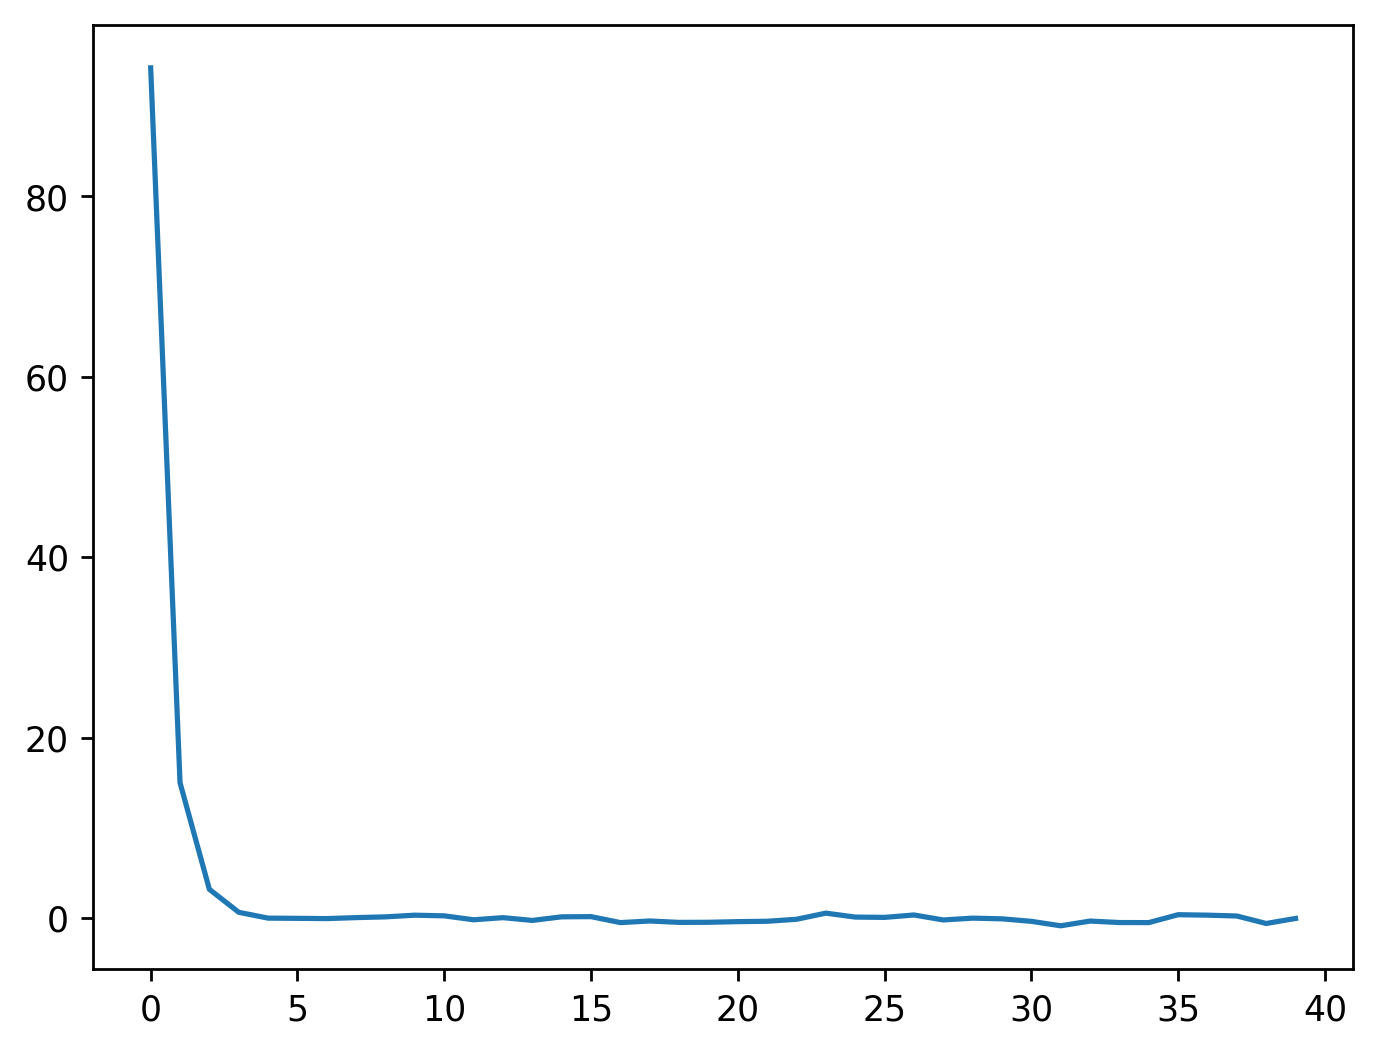

In [28]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_a_NN, color='tab:blue')
plt.show()

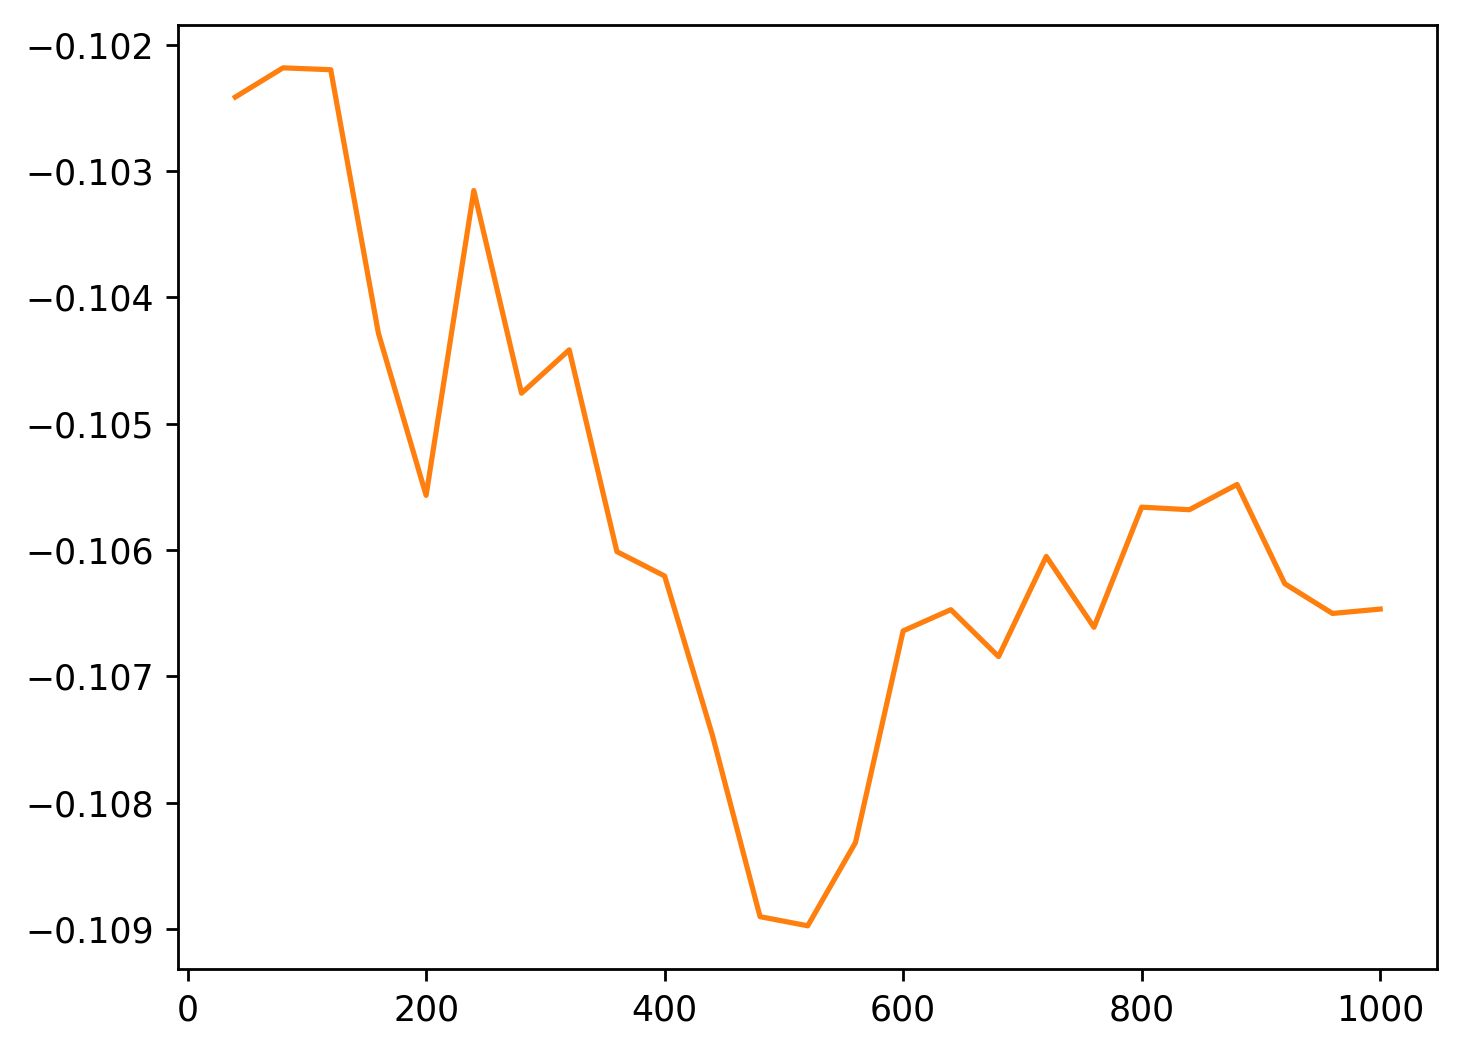

In [29]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_a_RF, color='tab:orange')
plt.show()

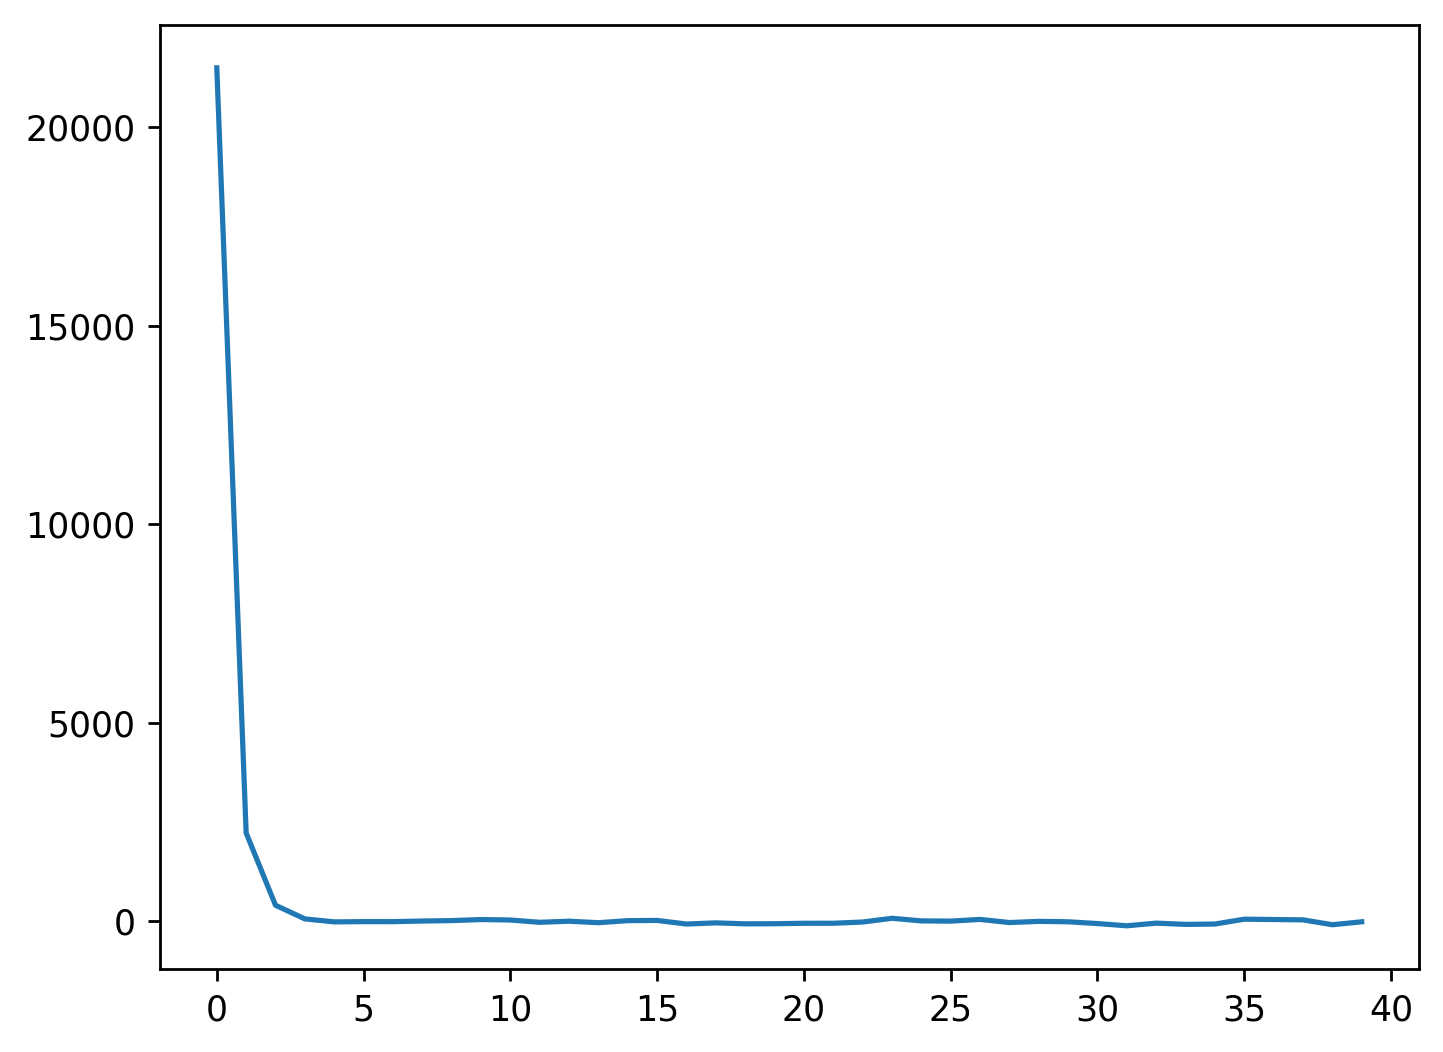

In [30]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_b_NN, color='tab:blue')
plt.show()

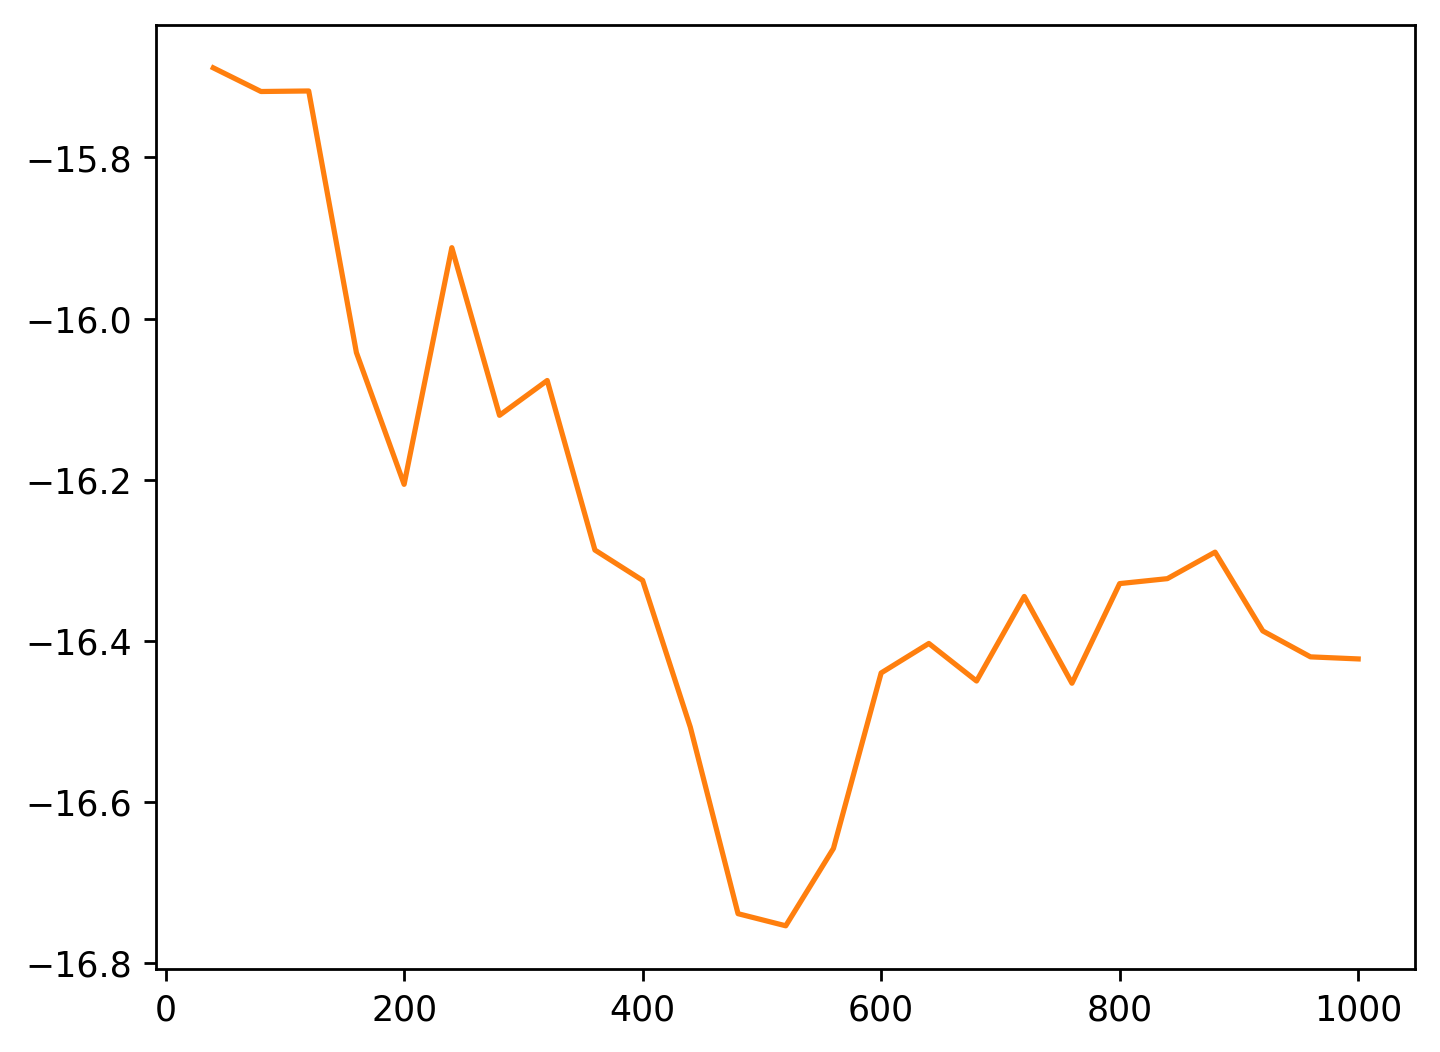

In [31]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_b_RF, color='tab:orange')
plt.show()

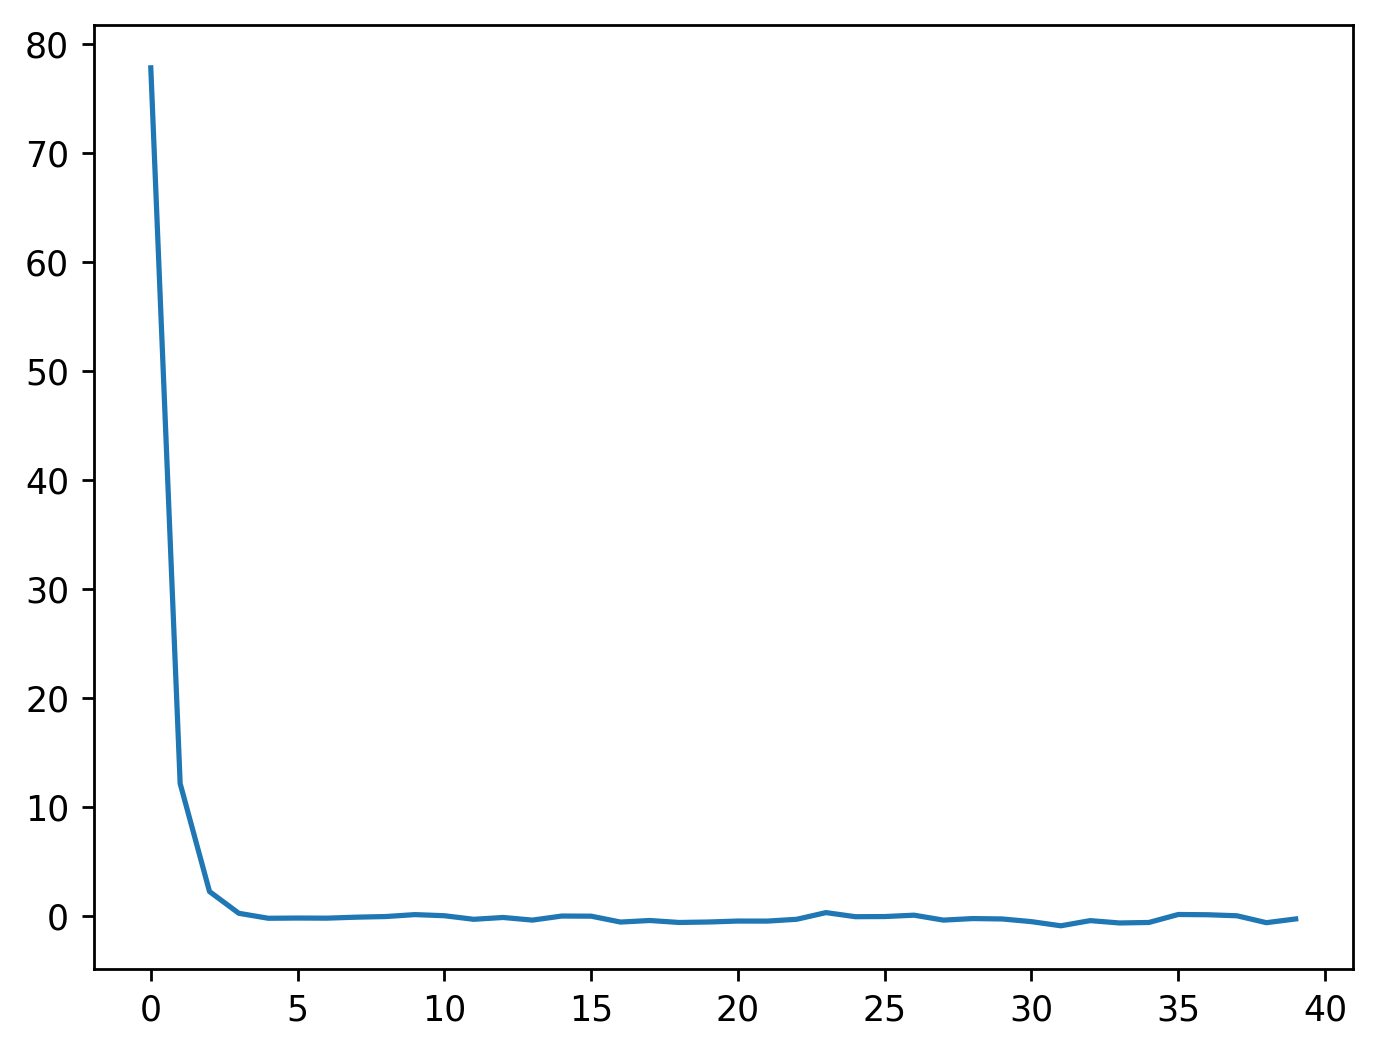

In [32]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_c_B_1_NN, color='tab:blue')
plt.show()

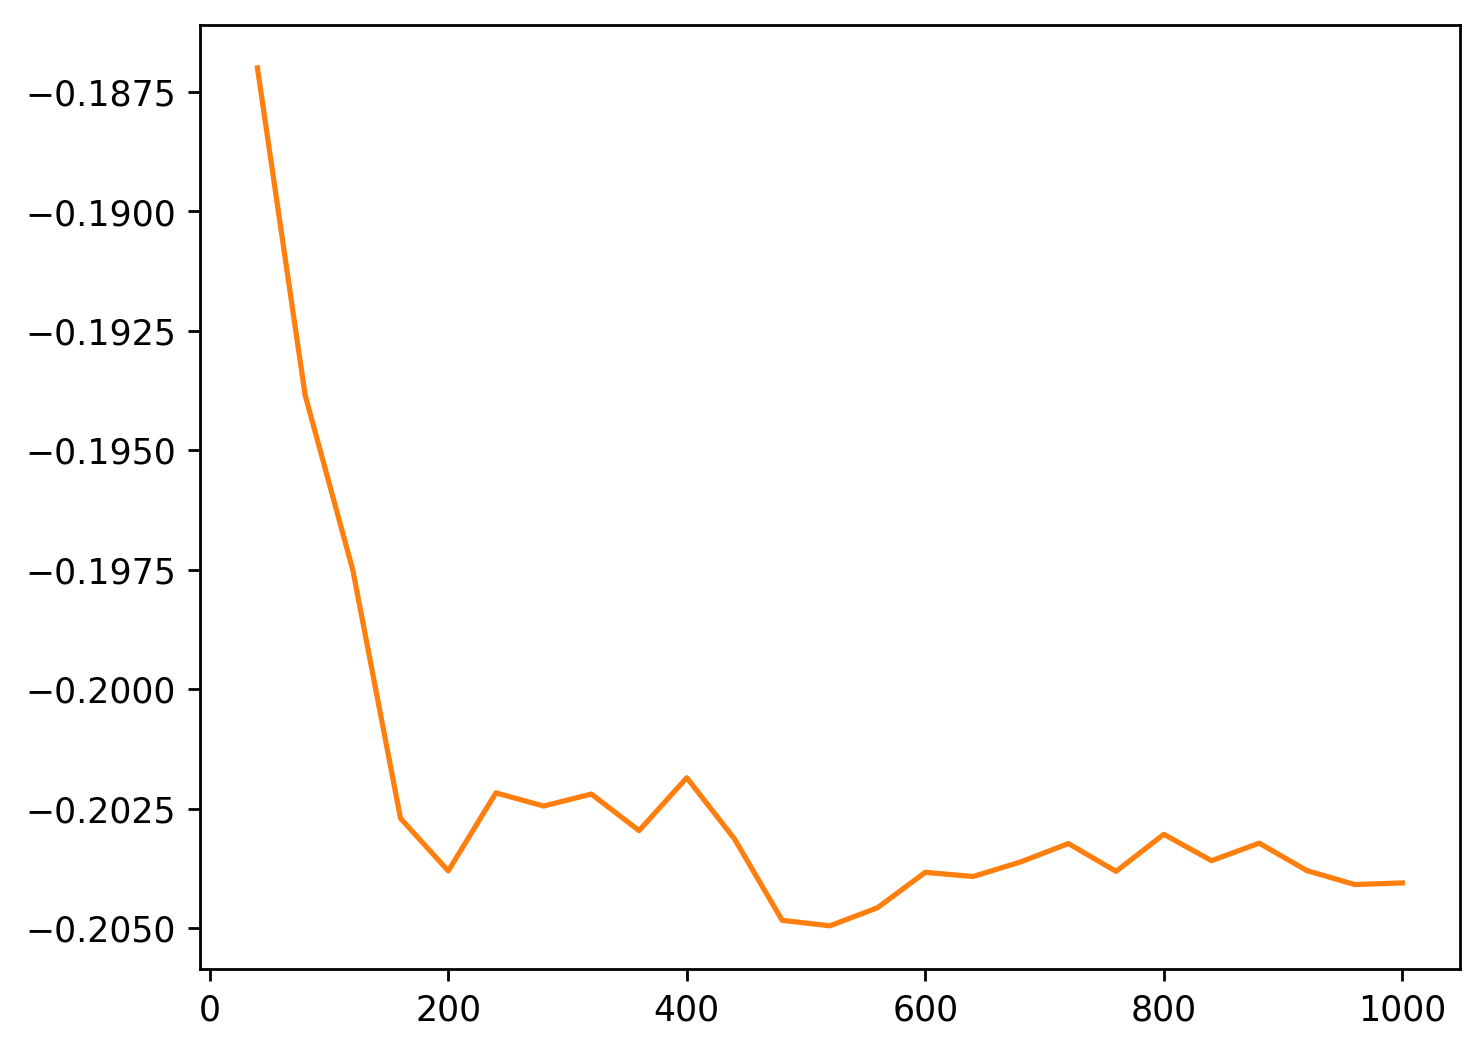

In [33]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_c_B_1_RF, color='tab:orange')
plt.show()

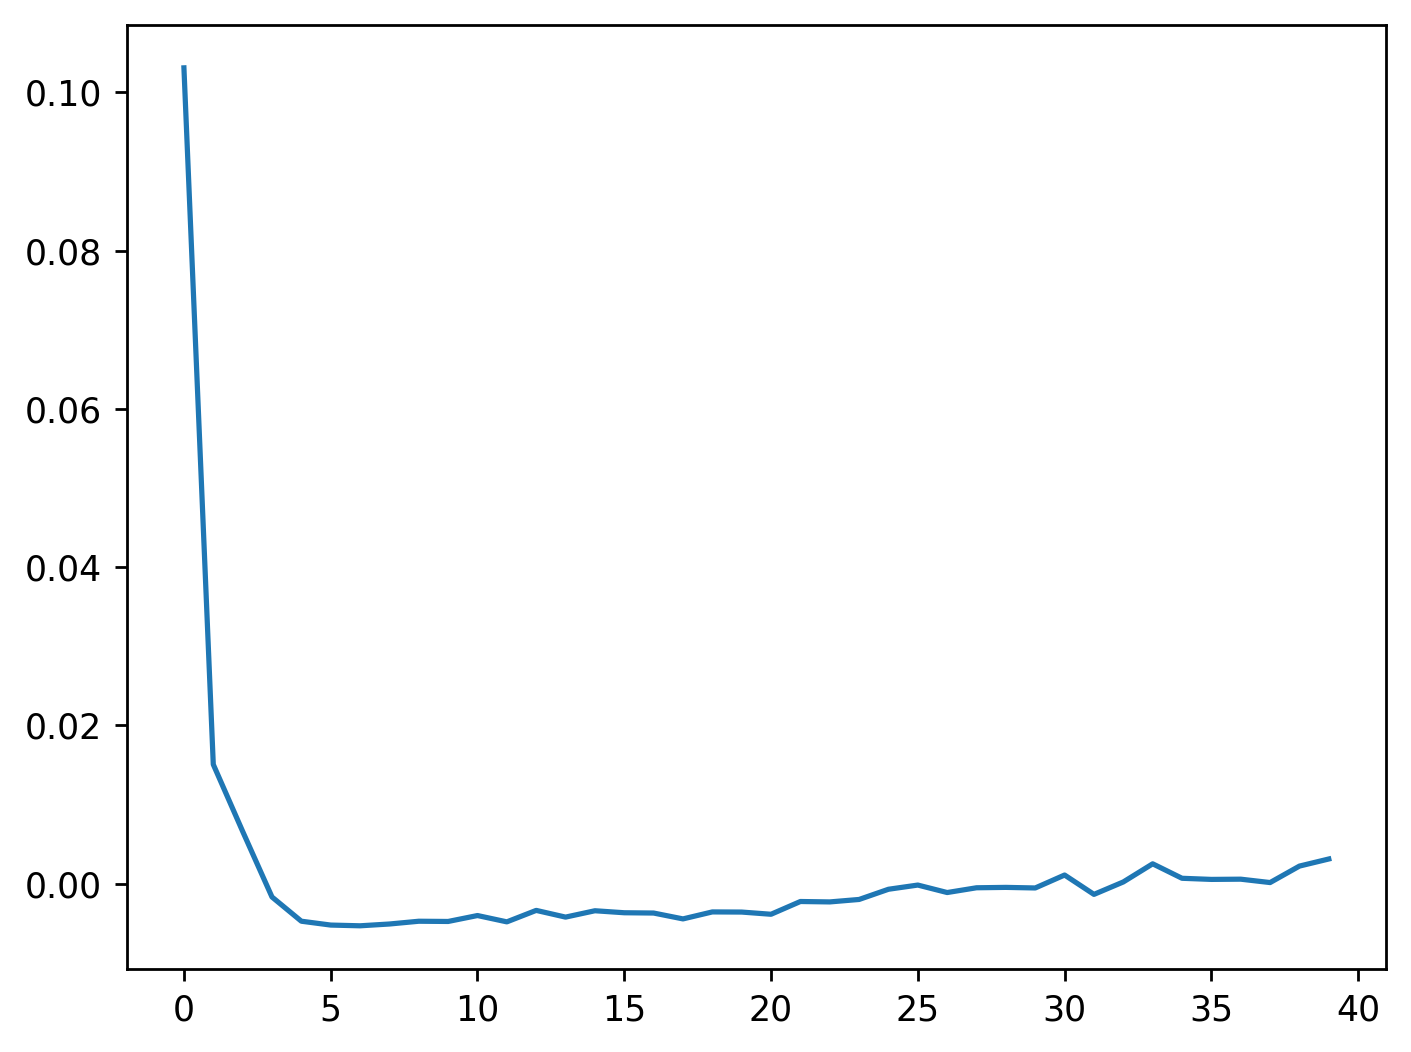

In [34]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),metric_c_B_2_NN, color='tab:blue')
plt.show()

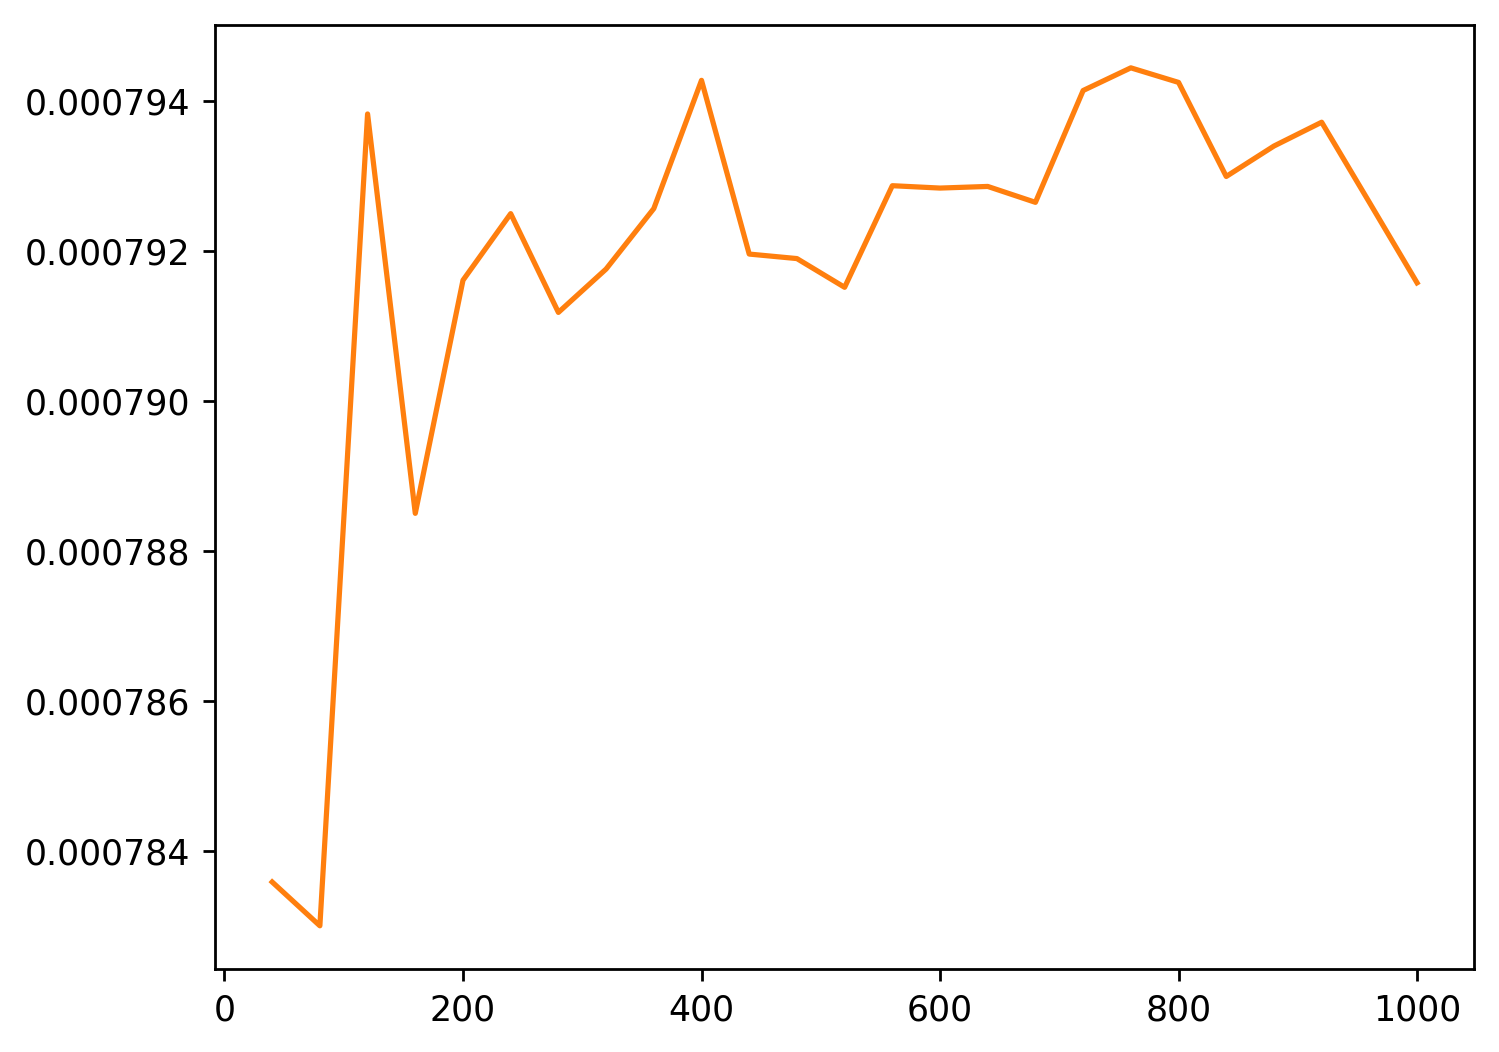

In [35]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_c_B_2_RF, color='tab:orange')
plt.show()

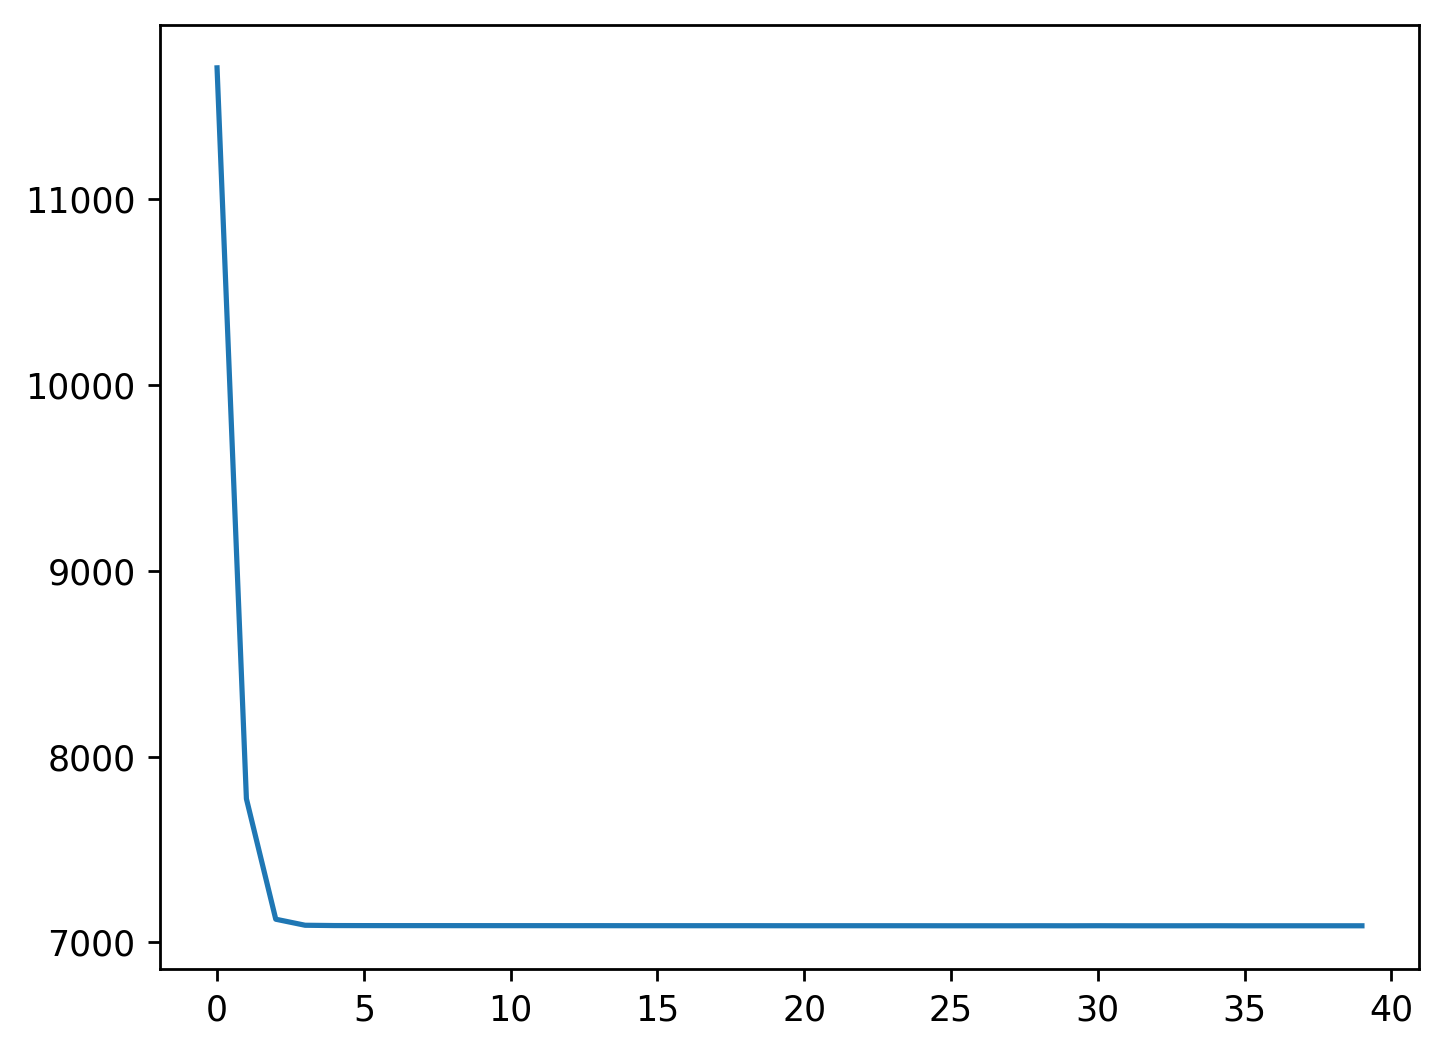

In [36]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),hist.history['mse'], color='tab:blue')
plt.show()

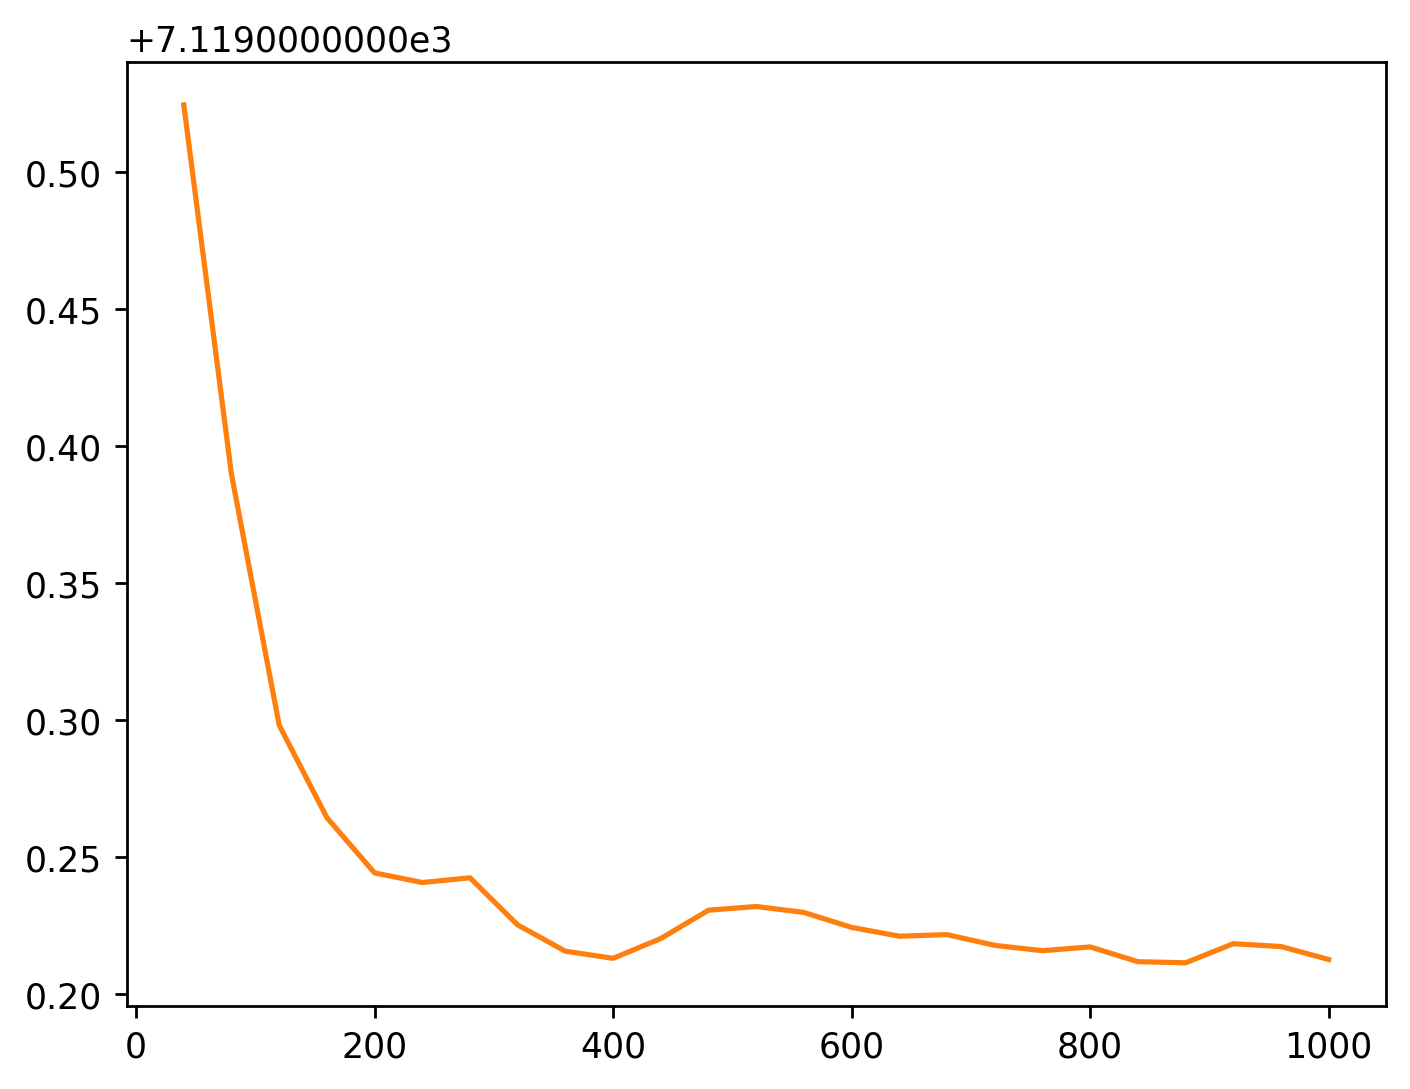

In [37]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,mse_train_RF, color='tab:orange')
plt.show()

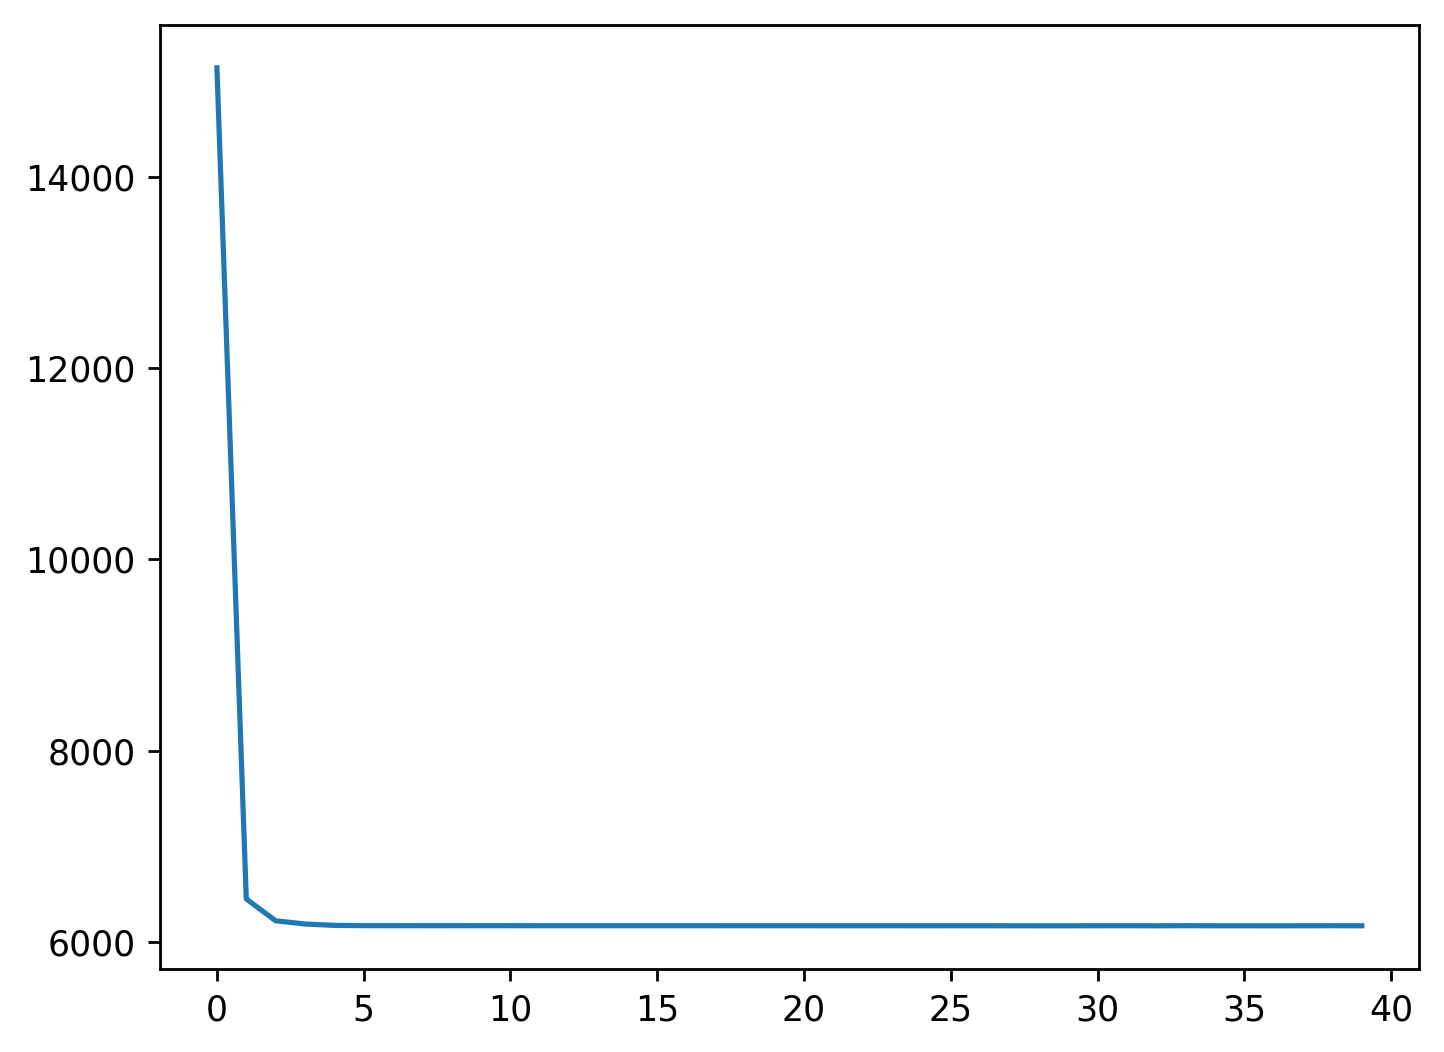

In [38]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(40),hist.history['val_mse'], color='tab:blue')
plt.show()

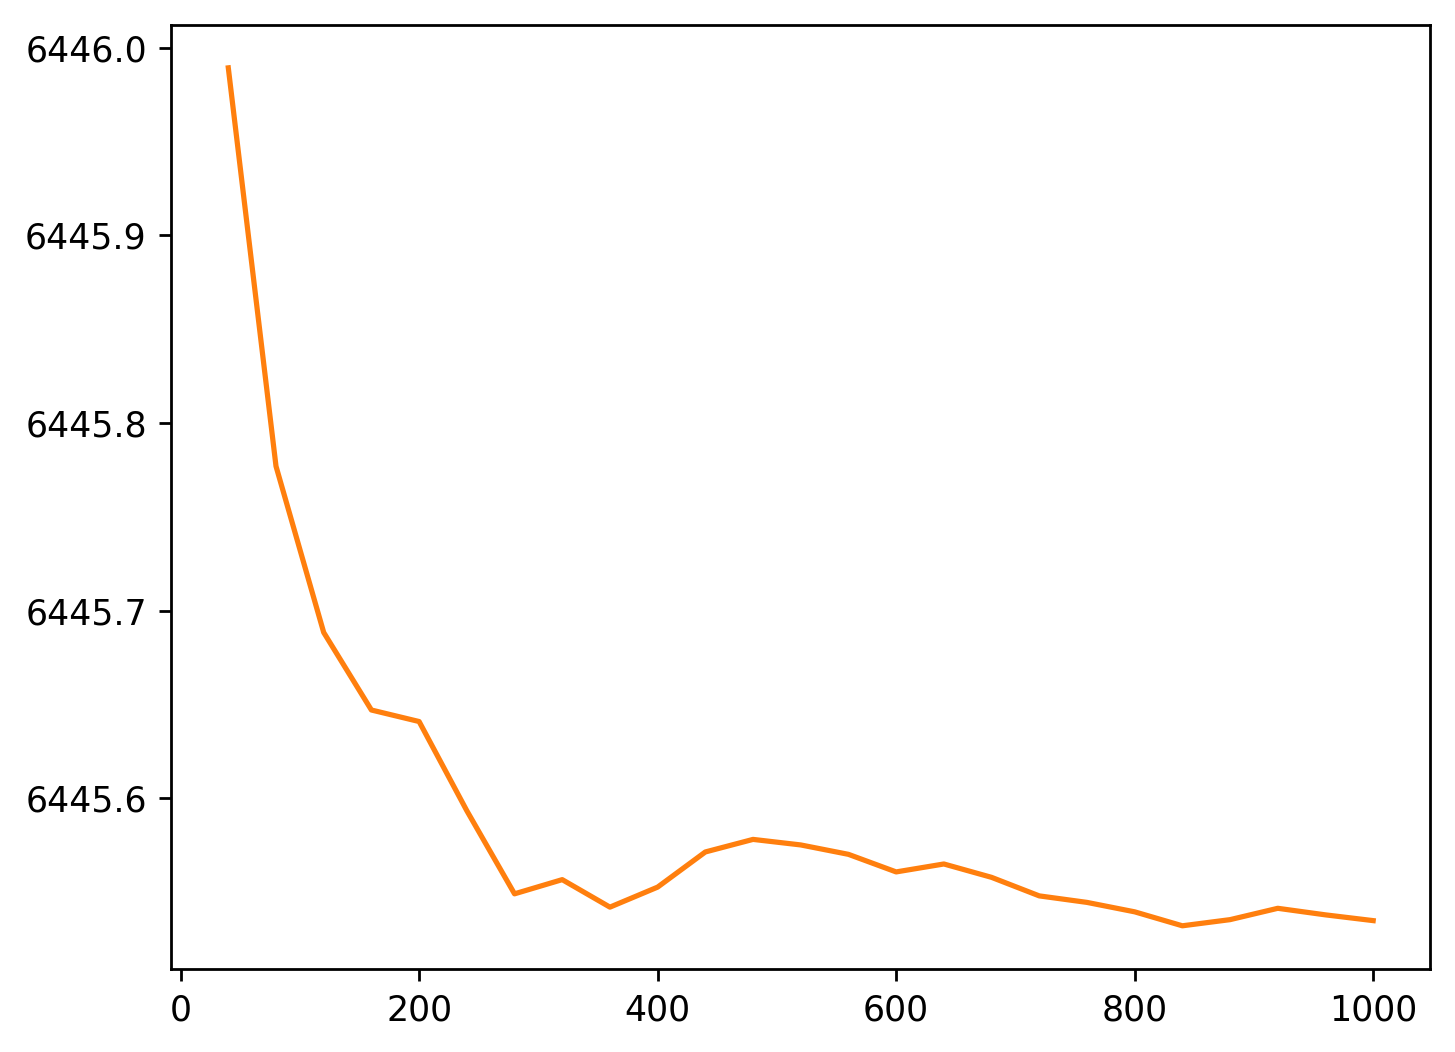

In [39]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,mse_val_RF, color='tab:orange')
plt.show()

Plots of the risk measure estimators calculated in the stepwise procedure.

In [40]:
steps = np.linspace(i, 500000, step_number)

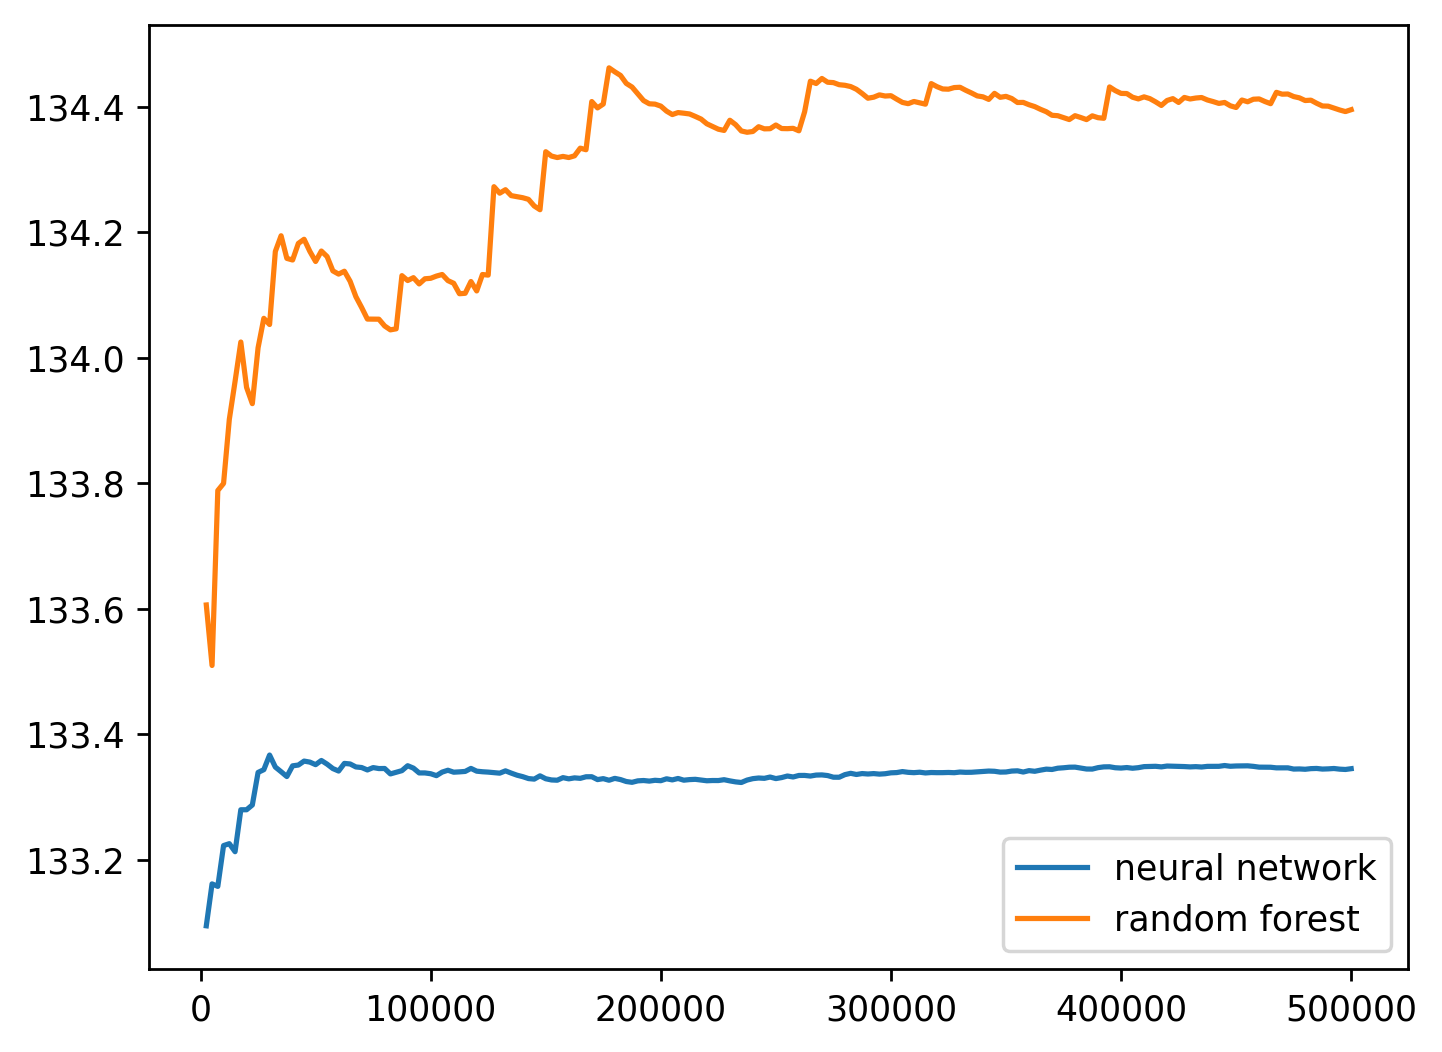

In [41]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(steps,GlueVaR_hat_NN, color='tab:blue')
plt.plot(steps,GlueVaR_hat_RF, color='tab:orange')
plt.legend(['neural network', 'random forest'])
plt.show()

In [42]:
#Saving the computed risk measure estimators such that they can be compared to estimators produced with usage of the importance sampling procedure in another notebook (single_run_eval.ipynb)
joblib.dump(GlueVaR_hat_NN, filepath+'GlueVaR_hat_IS_1_NN_'+str(int(M_IS/1000))+'.joblib')
joblib.dump(GlueVaR_hat_RF, filepath+'GlueVaR_hat_IS_1_RF_'+str(int(M_IS/1000))+'.joblib')

['/pfs/data5/home/ul/ul_student/ul_ynv73/VarAnn/saved_mix/GlueVaR_hat_IS_1_RF_750.joblib']